In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from einops import rearrange, repeat, reduce
import serial
from scipy import signal
from IPython.display import HTML
import time
from tqdm.notebook import tqdm
import pyvisa
import struct
import pandas as pd

np.set_printoptions(precision=4, suppress=True)

In [8]:
def sine_wave(t, freq, phase):
    phase = phase * np.pi / 180
    return np.sin(2 * np.pi * freq * t + phase)

def triangle_wave(t, freq, phase):
    phase = phase * np.pi / 180
    return signal.sawtooth(2 * np.pi * freq * t + phase, 0.5)

def sample_time(points, sample_rate):
    return np.linspace(0, points / sample_rate, points, endpoint=False, dtype=np.float32)

def noise(t, std):
    return np.random.normal(0, std, t.shape)

In [7]:
def read_data_csv(file_name):
    data = np.genfromtxt(file_name, delimiter=",", skip_header=2, usecols=3).astype(
        np.float32
    )
    data = data[::40]
    data = data[:1024] / 32768.0
    return data


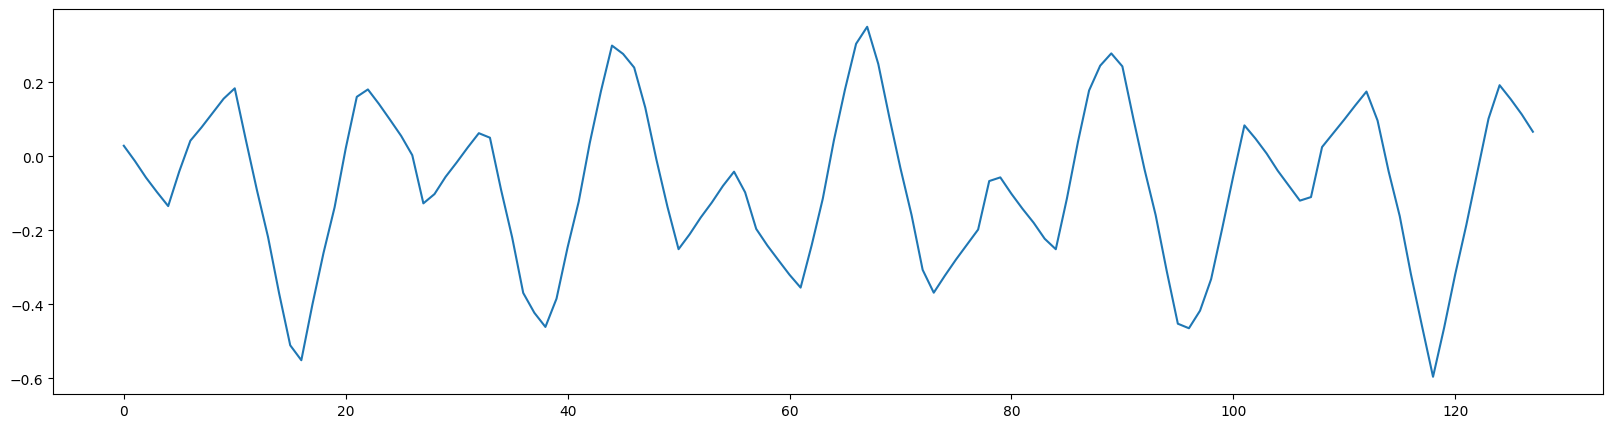

In [39]:
points = 1024
sample_rate = 1_024_000
t = sample_time(points, sample_rate)
plt.figure(figsize=(20, 5))
# y1 = triangle_wave(t, 50_000, 0)
# y2 = sine_wave(t, 90_000, 0)
# y = y1 + y2
# plt.plot(y1)
# plt.plot(y2)
# plt.plot(y)
y = read_data_csv('50_90_tri_tri.csv')
plt.plot(y[0:128])
plt.show()

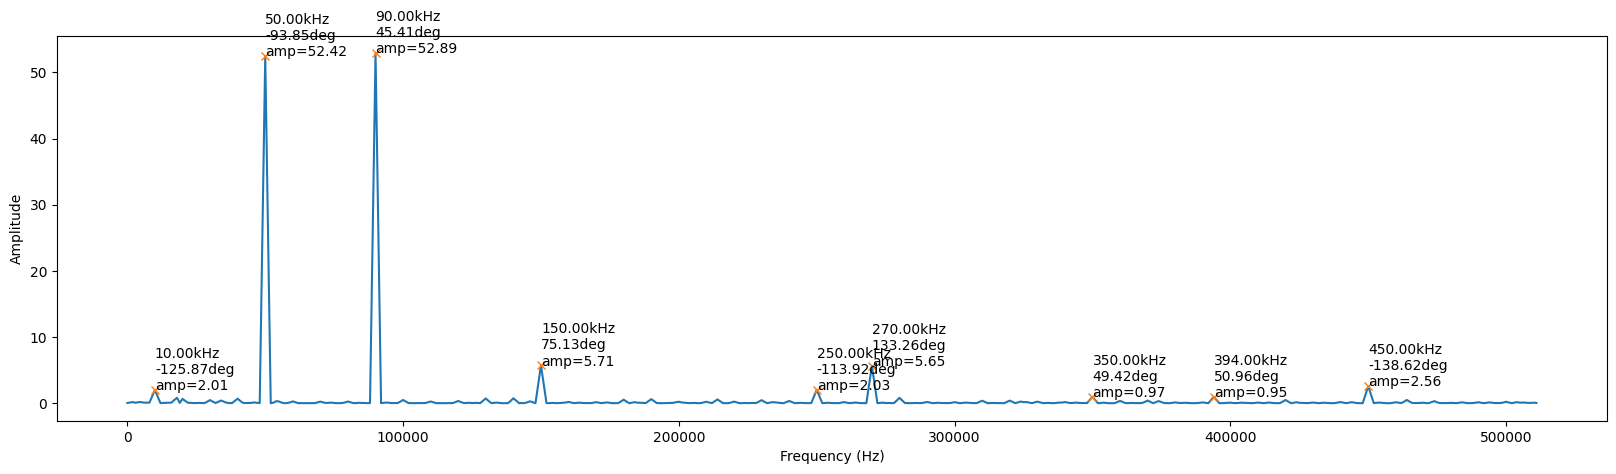

Background noise: 0.06+/-0.04


In [40]:
spectrum = np.fft.fft((y - np.mean(y)) * np.hanning(points))[0 : points // 2]
amp = np.abs(spectrum)
freq = np.fft.fftfreq(points, d=1 / sample_rate)[0 : points // 2]
background = np.mean(np.sort(amp)[100:400])
background_dev = np.std(np.sort(amp)[100:400])
peaks = signal.find_peaks(amp, height=background * 15)[0]
freqs = freq[peaks]
phases = np.rad2deg(np.angle(spectrum[peaks]))
plt.figure(figsize=(20, 5))
plt.plot(freq, amp)
plt.plot(freqs, amp[peaks], 'x')
for i in range(len(freqs)):
    plt.text(freqs[i], amp[peaks][i], f'{freqs[i]/1000:.2f}kHz\n{phases[i]:.2f}deg\namp={amp[peaks][i]:.2f}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

print(f'Background noise: {background:.2f}+/-{background_dev:.2f}')

In [85]:
def open_device():
    global device
    if 'device' in globals():
        if device is not None:
            device.close()
    rm = pyvisa.ResourceManager()
    devices = rm.list_resources()
    for d in devices:
        if d.startswith("USB0"):
            device = rm.open_resource(d)
            print("Device found: ", d)
            print(device.query("*IDN?"))
            return
    raise Exception("No device found")

In [102]:
SHAPE_SINE = 1
SHAPE_TRIANGLE = 2

def set_device_parameter(ch0_shape, ch0_freq, ch1_shape, ch1_freq, phase):
    global device
    device.write(f"C1:BSWV WVTP,{'RAMP' if ch0_shape == SHAPE_TRIANGLE else 'SINE'}")
    device.write(f"C1:BSWV FRQ,{ch0_freq}")
    device.write(f"C2:BSWV WVTP,{'RAMP' if ch1_shape == SHAPE_TRIANGLE else 'SINE'}")
    device.write(f"C2:BSWV FRQ,{ch1_freq}")
    device.write(f"C2:BSWV PHSE,{phase}")

In [4]:
def gen_random_test_data(n):
    ch0_shape = np.random.randint(1, 3, n)
    ch0_freq = np.random.randint(4, 20, n) * 5e3
    ch1_shape = np.random.randint(1, 3, n)
    ch1_freq = np.random.randint(5, 21, n) * 5e3
    phase = np.random.randint(0, 360, n)

    # make sure ch0_freq < ch1_freq
    while np.any(ch0_freq >= ch1_freq):
        ch0_freq = np.where(ch0_freq >= ch1_freq, ch0_freq - 5e3, ch0_freq)
    return ch0_shape, ch0_freq, ch1_shape, ch1_freq, phase

def gen_full_test_data():
    # Enumerate all possible combinations of test data
    # ch0_shape: 1 or 2
    # ch0_freq: 18 values from 20kHz to 100kHz
    # ch1_shape: 1 or 2
    # ch1_freq: 18 values from 20kHz to 100kHz, but ch1_freq > ch0_freq
    # phase: random from 0 to 360
    

In [43]:
def open_serial():
    global com
    com_port = "COM4"
    if "com" in globals():
        com.close()
    com = serial.Serial(
        port=com_port,
        baudrate=115200*4,
        bytesize=8,
        timeout=2,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
    )

def read_raw_data():
    global com
    if not com.is_open:
        open_serial()
    com.write(b"\x01")
    head = com.read_until(b"\xff\xff\xff\xff")
    if len(head) < 4:
        com.close()
        raise Exception("read_raw_data: head length error")
    buf = com.read(4096 * 2)
    data = np.frombuffer(buf, dtype=np.int16)
    com.close()
    return data.copy()

def read_signal_test():
    global com
    if not com.is_open:
        open_serial()
    com.write(b"\x03")
    head = com.read_until(b"\xff\xff\xff\xff")
    if len(head) < 4:
        com.close()
        raise Exception("read_signal_test: head length error")
    buf = com.read(4) # int32
    type_a = struct.unpack("i", buf)[0]
    buf = com.read(8) # double
    freq_a = struct.unpack("d", buf)[0]
    buf = com.read(4) # int32
    type_b = struct.unpack("i", buf)[0]
    buf = com.read(8) # double
    freq_b = struct.unpack("d", buf)[0]
    com.close()
    return type_a, freq_a, type_b, freq_b

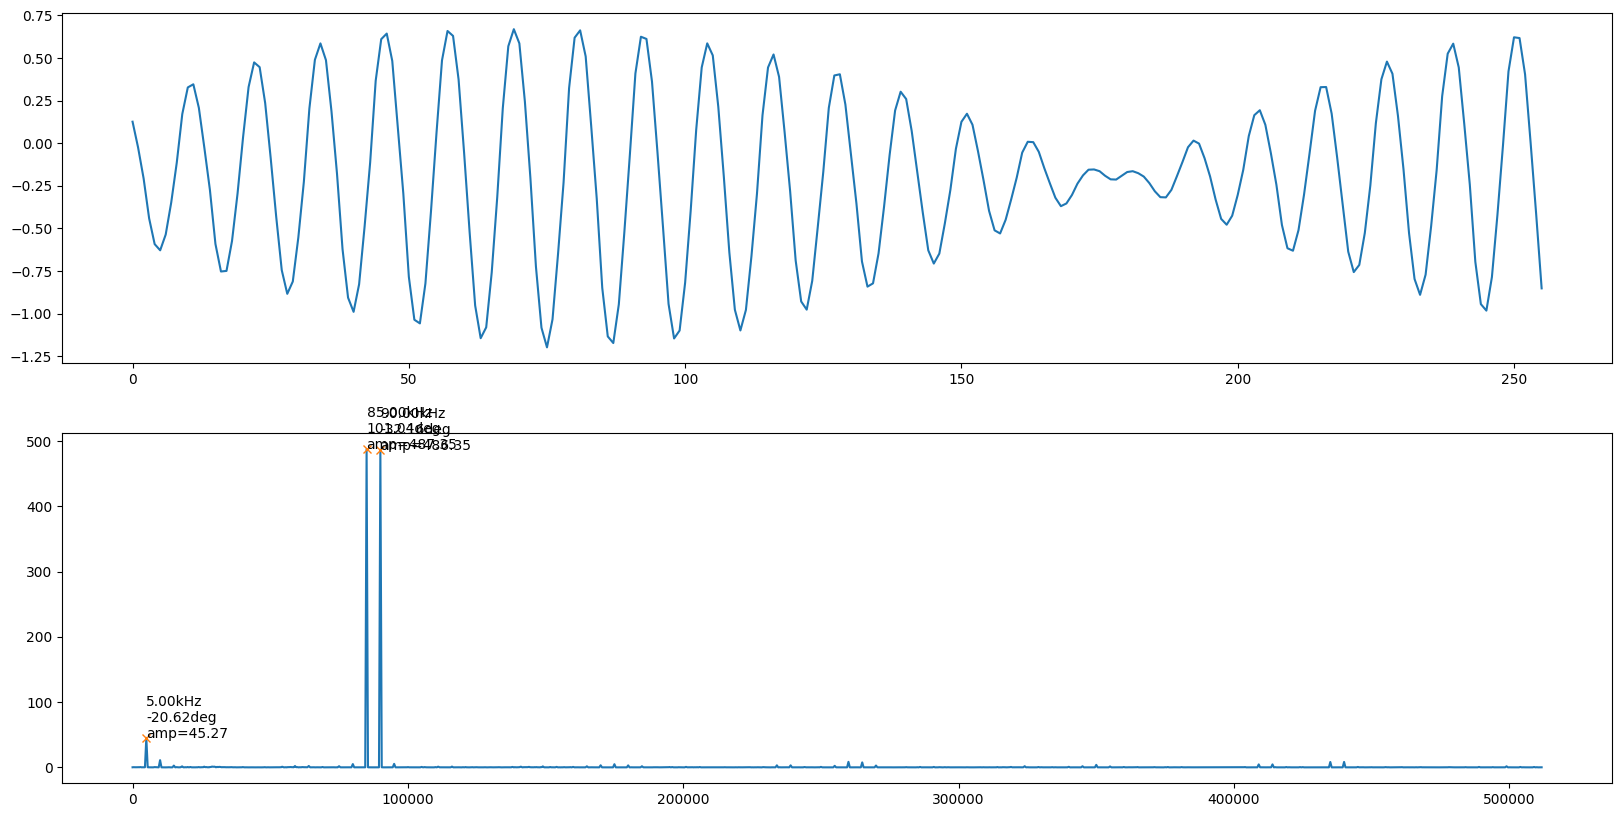

Background noise: 0.0279+/-0.0061


In [127]:
open_serial()
# Read and plot raw data from ADC
sample_rate = 40_960_000 / 40 # 1_024_000
data = read_raw_data().astype(np.float32)
data = data * 2 / 32768
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(data[:256])

y = data
points = y.shape[0]
spectrum = np.fft.fft((y - np.mean(y)) * np.hanning(points))[0 : points // 2]
amp = np.abs(spectrum)
freq = np.fft.fftfreq(points, d=1 / sample_rate)[0 : points // 2]
background = np.mean(np.sort(amp)[100:400])
background_dev = np.std(np.sort(amp)[100:400])
peaks = signal.find_peaks(amp, height=background * 500)[0]
freqs = freq[peaks]
phases = np.rad2deg(np.angle(spectrum[peaks]))
axs[1].plot(freq, amp)
axs[1].plot(freqs, amp[peaks], 'x')
for i in range(len(freqs)):
    axs[1].text(freqs[i], amp[peaks][i], f'{freqs[i]/1000:.2f}kHz\n{phases[i]:.2f}deg\namp={amp[peaks][i]:.2f}')
plt.show()

print(f'Background noise: {background:.4f}+/-{background_dev:.4f}')

In [100]:
open_device()

Device found:  USB0::0xF4EC::0x1102::SDG2XBA4150426::INSTR
Siglent Technologies,SDG2122X,SDG2XBA4150426,2.01.01.37R6



In [129]:
test_cases = 100
ch0_shape, ch0_freq, ch1_shape, ch1_freq, phase = gen_random_test_data(test_cases)
result_ch0_shape = np.zeros_like(ch0_shape)
result_ch0_freq = np.zeros_like(ch0_freq)
result_ch1_shape = np.zeros_like(ch1_shape)
result_ch1_freq = np.zeros_like(ch1_freq)

In [130]:
for i in tqdm(range(test_cases)):
    set_device_parameter(ch0_shape[i], ch0_freq[i], ch1_shape[i], ch1_freq[i], phase[i])
    time.sleep(1)
    r_ch0_shape, r_ch0_freq, r_ch1_shape, r_ch1_freq = read_signal_test()
    result_ch0_shape[i] = r_ch0_shape
    result_ch0_freq[i] = r_ch0_freq
    result_ch1_shape[i] = r_ch1_shape
    result_ch1_freq[i] = r_ch1_freq

df = pd.DataFrame(
    {
        "ch0_shape": ch0_shape,
        "r_ch0_shape": result_ch0_shape,
        "ch0_freq": ch0_freq,
        "r_ch0_freq": result_ch0_freq,
        "ch1_shape": ch1_shape,
        "r_ch1_shape": result_ch1_shape,
        "ch1_freq": ch1_freq,
        "r_ch1_freq": result_ch1_freq,
        "phase": phase,
    }
)
df.to_csv("test.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [133]:
print(f"Ch0 shape correct: {np.count_nonzero(ch0_shape == result_ch0_shape)}")
print(f"Ch1 shape correct: {np.count_nonzero(ch1_shape == result_ch1_shape)}")
print(
    f"Ch0 freq correct: {np.count_nonzero(np.isclose(np.round(ch0_freq / 5000), np.round(result_ch0_freq / 5000)))}"
)
print(
    f"Ch1 freq correct: {np.count_nonzero(np.isclose(np.round(ch1_freq / 5000), np.round(result_ch1_freq / 5000)))}"
)
np.where(ch1_shape != result_ch1_shape)[0]

Ch0 shape correct: 100
Ch1 shape correct: 99
Ch0 freq correct: 99
Ch1 freq correct: 99


array([34], dtype=int64)

In [138]:
i = 34
set_device_parameter(ch0_shape[i], ch0_freq[i], ch1_shape[i], ch1_freq[i], phase[i])
time.sleep(1)
read_signal_test()

(2, 55000.0, 2, 60000.0)